In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from Environments.Stochastic_GridWorld8Actions import GridWorld

In [2]:
def smoothing_data(rewards_across_seeds, traps_across_seeds, variance_across_seeds):

    kernel_size = 11000
    kernel = np.ones(kernel_size) / kernel_size

    all_rewards = []
    for data in rewards_across_seeds:
        rewards = np.convolve(data, kernel)
        all_rewards.append(rewards[kernel_size:-kernel_size])

    all_traps = []
    for data in traps_across_seeds:
        traps = data
        all_traps.append(traps)

    # all_variance_rewards = []
    # for data in variance_across_seeds:
    #     variance_rewards = np.convolve(data, kernel)
    #     all_variance_rewards.append(variance_rewards[kernel_size:-kernel_size])


    return all_rewards, all_traps#, all_variance_rewards


In [3]:
class Table_Q_Learning():
    def __init__(self, action_space = 8, state_space = 100, lr = 0.0001, gamma = 0.99, epsilon = 0.91, 
                 annealing_coefficient =  0.9999999, beta = 0, seed = 0):
        self.rng = np.random.default_rng( seed )
        
        self.action_space = action_space
        self.state_space = state_space

        self.possible_actions = np.arange(action_space)

        self.lr = lr #learning rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.annealing_coefficient = annealing_coefficient
        
        self.beta = beta

        self.q_table = [
                        [0.0] * action_space
                        for _ in range(state_space)
                        ] 

        self.pi_table = [
                        [1.0/action_space] * action_space
                        for _ in range(state_space)
                        ]
                        
        self.state_entropy = {}
        
        #self.environment_terminal_states = environment_terminal_states

    def update(self, current_state, action, next_state, reward, done, env_obj):    
        
        max_next_q = np.max(self.q_table[next_state])
        n_max_next_q = 0
        for q in self.q_table[next_state]:
            if(q == max_next_q):
                n_max_next_q +=1

        non_greedy_actions_prob = self.epsilon / self.action_space
        greedy_action_prob = (1-self.epsilon)/n_max_next_q + non_greedy_actions_prob

        expected_q = 0

        for i in range(self.action_space):
            if(self.q_table[next_state][i] == max_next_q):
                expected_q += greedy_action_prob * self.q_table[next_state][i]
            else:
                expected_q += non_greedy_actions_prob * self.q_table[next_state][i]  

        td_error = reward + self.gamma * expected_q * (1-done) - self.q_table[current_state][action]
  
        k = self.beta

        k_plus = (1 - k)
        k_minus = (1 + k)


        if td_error >= 0:
            td_error = k_plus * np.tanh(1/4 * td_error )
        else:
            td_error = k_minus * np.tanh(1/4 * td_error )
        
        self.q_table[current_state][action] +=  self.lr * td_error

        #annealing epsilon
        if self.epsilon > 0.1:
            self.epsilon *= self.annealing_coefficient

    def take_action(self, current_state, epsilon = None):
        ep_policy = 0
        if epsilon == None:
            ep_policy = self.epsilon
        else:
            ep_policy = epsilon

        if(self.rng.random() < ep_policy):
            random_possible_action = self.rng.choice(self.possible_actions)

            q_action = self.q_table[current_state][random_possible_action]

            return random_possible_action, q_action, self.q_table[current_state]
        else:
            max_action = np.argmax(self.q_table[current_state])
            max_q_action = np.max(self.q_table[current_state])

            return max_action, max_q_action, self.q_table[current_state]

    

    # def compute_normalized_policy_entropy(self,state):
    #     pi = np.array(self.pi_table[state])
    #     #epsilon = 1e-10  # A small value to prevent log2(0)
    #     norm_entropy = -np.sum((pi) * np.log2(pi)) / np.log2(8) #8 is the action space
    #     return norm_entropy

        
    # def compute_the_know_norm_transition_entropy(self, env_obj, state):
    #     w = 0.8
    #     epsilon = 1e-10
    #     all_entropy_current_state = 0

    #     for i in range(len(env_obj.state_transitions[state])): #actions
    #         all_next_states = np.array(env_obj.state_transitions[state][i])[:,1]
    #         all_distinct_next_state = np.unique(all_next_states)

    #         #this is required for transition estimation (removing the None value)
    #         all_distinct_next_state = all_distinct_next_state[all_distinct_next_state != np.array(None)]

    #         all_entropy_next_state = 0
    #         for j in all_distinct_next_state:
    #             for k in range(len(env_obj.state_transitions[j])):

    #                 if ( j in self.environment_terminal_states): #Terminal states get entropy of 0
    #                     continue
            
    #                 probs_next_state = np.array(env_obj.state_transitions[j][k])[:,0]
    #                 entropy_next_state = -np.sum((probs_next_state + epsilon) * np.log2(probs_next_state + epsilon)) / np.log2(len(probs_next_state))
    #                 all_entropy_next_state += entropy_next_state / len(env_obj.state_transitions[j])

    #         all_entropy_next_state = all_entropy_next_state/len(all_distinct_next_state)

    #         probs_current_state = np.array(env_obj.state_transitions[state][i])[:,0]
    #         entropy_current_state = -np.sum((probs_current_state + epsilon) * np.log2(probs_current_state + epsilon)) / np.log2(len(probs_current_state))
    #         all_entropy_current_state += w * entropy_current_state  + (1-w) * all_entropy_next_state

    #     return all_entropy_current_state / len(env_obj.state_transitions[state])
    

    # def compute_the_know_norm_transition_entropy(self, env_obj, state):
    #     #w = 0.8
    #     epsilon = 1e-10
    #     #all_entropy_current_state = 0
    #     all_entropy_next_state_arr = []
    #     for i in range(len(env_obj.state_transitions[state])): #actions
    #         all_next_states = np.array(env_obj.state_transitions[state][i])[:,1]
    #         all_distinct_next_state = np.unique(all_next_states)

    #         #this is required for transition estimation (removing the None value)
    #         all_distinct_next_state = all_distinct_next_state[all_distinct_next_state != np.array(None)]

            
    #         all_entropy_next_state = 0
    #         for j in all_distinct_next_state:
                
    #             for k in range(len(env_obj.state_transitions[j])):

    #                 if ( j in self.environment_terminal_states): #Terminal states get entropy of 0
    #                     continue
            
    #                 probs_next_state = np.array(env_obj.state_transitions[j][k])[:,0]
    #                 entropy_next_state = -np.sum((probs_next_state + epsilon) * np.log2(probs_next_state + epsilon)) / np.log2(len(probs_next_state))
    #                 all_entropy_next_state += entropy_next_state / len(env_obj.state_transitions[j])

    #             #dict_entropy_next_state[j] = arr_entropy_next_state

    #         all_entropy_next_state = all_entropy_next_state/len(all_distinct_next_state)
    #         all_entropy_next_state_arr.append(all_entropy_next_state)
    #         #probs_current_state = np.array(env_obj.state_transitions[state][i])[:,0]
    #         #entropy_current_state = -np.sum((probs_current_state + epsilon) * np.log2(probs_current_state + epsilon)) / np.log2(len(probs_current_state))
    #         #all_entropy_current_state += w * entropy_current_state  + (1-w) * all_entropy_next_state
    #         #dict_entropy_current_state[i] = dict_entropy_next_state
    #     return all_entropy_next_state_arr

    def compute_the_know_norm_transition_entropy(self, env_obj, state):
        
        epsilon = 1e-10
        all_entropy_current_state = []
        if( state in self.environment_terminal_states): #Terminal states get entropy of 0
            all_entropy_current_state = [0.0] * self.action_space
        else:
            for i in range(len(env_obj.state_transitions[state])): #actions
                probs_current_state = np.array(env_obj.state_transitions[state][i])[:,0]
                entropy_current_state = -np.sum((probs_current_state + epsilon) * np.log2(probs_current_state + epsilon)) / np.log2( len(probs_current_state) )
                all_entropy_current_state.append(entropy_current_state)

                # probs_current_state = np.array(env_obj.state_transitions[state][i])[:,0]
                # normalization_factor = np.log(len(probs_current_state))/np.log(2)
                
                # entropy_current_state = -np.sum((probs_current_state + epsilon) * (np.log(probs_current_state + epsilon)/np.log(2)))
                # entropy_current_state = entropy_current_state/normalization_factor
                # all_entropy_current_state.append(entropy_current_state)
                
        return all_entropy_current_state

    def set_RDG_seed(self, seed):
        self.rng = np.random.default_rng(seed)
    


In [4]:
transitions_variance = []

file = open('test_transitions_for_variance_1.0.pickle', 'rb')
# dump information to that file
transition = pickle.load(file)
transitions_variance.append(transition)
# close the file
file.close()

# file = open('test_transitions_for_variance_0.3.pickle', 'rb')
# # dump information to that file
# transition = pickle.load(file)
# transitions_variance.append(transition)
# # close the file
# file.close()

# file = open('test_transitions_for_variance_0.5.pickle', 'rb')
# # dump information to that file
# transition = pickle.load(file)
# transitions_variance.append(transition)
# # close the file
# file.close()

# file = open('test_transitions_for_variance_0.7.pickle', 'rb')
# # dump information to that file
# transition = pickle.load(file)
# transitions_variance.append(transition)
# # close the file
# file.close()

In [5]:
# transitions = []
# for i in range(10):
#     file = open('transition{0}.pickle'.format(i), 'rb')
#     # dump information to that file
#     transition = pickle.load(file)
#     transitions.append(transition)
#     # close the file
#     file.close()

In [6]:
# env_obj = GridWorld(x_dim = 6, y_dim = 6, deterministic_T_prob = 0.20, reward_location=30)

# # env_obj.state_transitions = transitions[1]
# env_obj.set_penalty(2,1)
# env_obj.set_penalty(2,3)

# # env_obj.set_penalty(0,2)
# # env_obj.set_penalty(1,2)

# # env_obj.set_penalty(2,4)
# # env_obj.set_penalty(3,4)
# # env_obj.set_penalty(4,4)
# # env_obj.set_penalty(5,4)

# # env_obj.set_penalty(6,6)
# # env_obj.set_penalty(2,1)
# # env_obj.set_penalty(2,3)

In [7]:
# attribute_list = np.array( list(env_obj.state_attributes.values()) )

# terminal_states = np.where(attribute_list == 0) #+ np.where(attribute_list == 2)

# terminal_states = np.concatenate( terminal_states )


In [8]:
for beta_data in [0,0.2,0.3,0.4,0.6,0.8]:
    env_obj = GridWorld(x_dim = 7, y_dim = 7, deterministic_T_prob = 1.0, reward_location=42) 
    env_obj.state_transitions = transitions_variance[0]

    # env_obj.set_penalty(2, 1)
    # env_obj.set_penalty(4, 3)
    # env_obj.set_penalty(3, 4)

    env_obj.set_penalty(2, 1)
    env_obj.set_penalty(4, 3)
    env_obj.set_penalty(3, 4)


    traps_across_seeds = []
    rewards_across_seeds = []
    std_across_seeds = []

    trajectory_heat_map_arr = []
    q_values_across_seeds = []

    for seed in range(4):

        EPISODES = 800000
        
        traps = np.zeros(EPISODES)
        rewards_arr_episodes = []
        std_per_episode = []

        agent_obj = Table_Q_Learning(lr = 0.01, state_space=49, annealing_coefficient =  0.999999,
                                      beta = beta_data, seed=seed)
        trajectory_heat_map = np.zeros((7,7))
        q_values_arr = []
        
        for i in range(EPISODES): #episodes
        
            state = env_obj.reset()[0]
            mean_episodic_reward = 0
            #variance_episodic_reward = 0
            #std_episodic_reward = 0
            
            for j in range(1,5001): #steps    

                action, q, all_q = agent_obj.take_action( state ) 
                new_state, reward, done, _ = env_obj.step(state, action)
                new_state = new_state[0]
                
                tempx = (reward - mean_episodic_reward)
                mean_episodic_reward += tempx / j
                # This difference is with respect to the updated mean
                #squared_difference = (reward - mean_episodic_reward)**2
                #variance_episodic_reward = ((j-1)*variance_episodic_reward + squared_difference) / j
                #std_episodic_reward = np.sqrt(variance_episodic_reward)

                agent_obj.update(state, action, new_state, reward, done, env_obj)


               
                x, y = np.where(env_obj.grid == state)
                trajectory_heat_map[x[0]][y[0]] +=1
            
                
                if(done == 1):
                    
                    x, y = np.where(env_obj.grid == new_state)
                    trajectory_heat_map[x[0]][y[0]] +=1

                     
                    # if i % 1000 == 0 and i > 140000:
                    #     print("Episode ",i, " Epsilon ",agent_obj.epsilon, " mean reward ",mean_episodic_reward)
                    if(env_obj.state_attributes[new_state] == 2):
                        traps[i] = 1
                    break

                state = new_state
        

            rewards_arr_episodes.append(mean_episodic_reward)
            #q_values_arr.append(agent_obj.q_table)
            #std_per_episode.append(std_episodic_reward)

        traps_across_seeds.append(traps)
        rewards_across_seeds.append(rewards_arr_episodes)
        std_across_seeds.append(std_per_episode)
        trajectory_heat_map_arr.append(trajectory_heat_map)
        q_values_across_seeds.append(agent_obj.q_table)

    all_rewards, all_traps = smoothing_data(rewards_across_seeds, traps_across_seeds, std_across_seeds)
    # with open('Prospect_framework_reward_zeta_test_'+str(zeta_data)+'.pickle', 'wb') as file:
    #     pickle.dump(all_rewards, file)

    with open('Prospect_framework_traps_zeta_test_'+str(beta_data)+'.pickle', 'wb') as file:
        pickle.dump(all_traps, file)

    # # with open('Prospect_framework_variance_'+determinism+'.pickle', 'wb') as file:
    # #     pickle.dump(all_variance_rewards, file)

    with open('Prospect_framework_heatmap_beta_test_'+str(beta_data)+'.pickle', 'wb') as file:
        pickle.dump(trajectory_heat_map_arr, file)
    
    with open('Prospect_framework_q_value_beta_test_'+str(beta_data)+'.pickle', 'wb') as file:
        pickle.dump(q_values_across_seeds, file)
    


In [9]:
file = open('Prospect_framework_heatmap_beta_test_0.8.pickle', 'rb')
# dump information to that file
heatmap = pickle.load(file)
file.close()

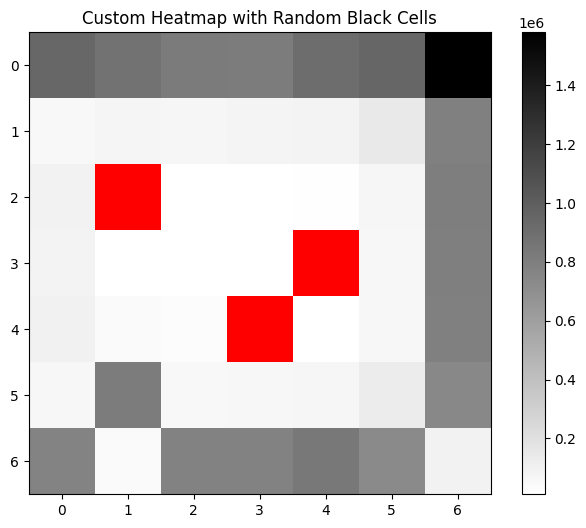

In [10]:
custom_data_array = heatmap[2].copy()

# Define number of random cells to set as black
# number_of_black_cells = 5

# Randomly choose grid cells to be black
black_indices = set()
# while len(black_indices) < number_of_black_cells:
    # i = random.randint(0, 5)
    # j = random.randint(0, 5)
# black_indices.add((2, 0))
# black_indices.add((3, 0))
# black_indices.add((4, 0))

# black_indices.add((3, 2))
# black_indices.add((4, 2))

# black_indices.add((2, 4))

black_indices.add((2, 1))
black_indices.add((4, 3))
black_indices.add((3, 4))

# Set these cells' values high enough to be distinguished for custom coloring
high_value = np.max(heatmap[2]) + 1  # One more than the max value in the data
for (i, j) in black_indices:
    custom_data_array[i, j] = high_value

# Create a custom colormap
from matplotlib.colors import LinearSegmentedColormap

colors = ["white", "black"]  # White to light green for normal cells
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)
cmap.set_over('red')  # Black for the high value cells

# Plotting the heatmap with the custom colormap
plt.figure(figsize=(8, 6))
heatmap = plt.imshow(custom_data_array, cmap=cmap, interpolation='nearest', vmax=np.max(heatmap[2]))
plt.colorbar(heatmap)
plt.title("Custom Heatmap with Random Black Cells")
plt.show()

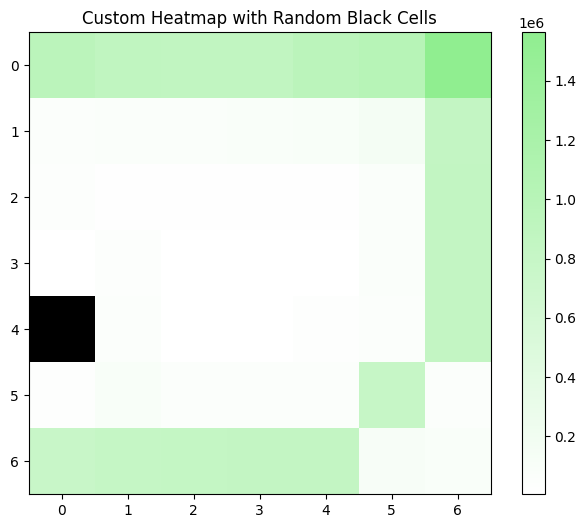

In [11]:
custom_data_array = trajectory_heat_map.copy()

# Define number of random cells to set as black
# number_of_black_cells = 5

# Randomly choose grid cells to be black
black_indices = set()
# while len(black_indices) < number_of_black_cells:
    # i = random.randint(0, 5)
    # j = random.randint(0, 5)
black_indices.add((4, 0))

# Set these cells' values high enough to be distinguished for custom coloring
high_value = np.max(trajectory_heat_map) + 1  # One more than the max value in the data
for (i, j) in black_indices:
    custom_data_array[i, j] = high_value

# Create a custom colormap
from matplotlib.colors import LinearSegmentedColormap

colors = ["white", "lightgreen"]  # White to light green for normal cells
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)
cmap.set_over('black')  # Black for the high value cells

# Plotting the heatmap with the custom colormap
plt.figure(figsize=(8, 6))
heatmap = plt.imshow(custom_data_array, cmap=cmap, interpolation='nearest', vmax=np.max(trajectory_heat_map))
plt.colorbar(heatmap)
plt.title("Custom Heatmap with Random Black Cells")
plt.show()

In [12]:
file = open('Prospect_framework_reward_1.0.pickle', 'rb')
# dump information to that file
prospect1_rewards = pickle.load(file)
# close the file
file.close()

file = open('Prospect_framework_traps_1.0.pickle', 'rb')
# dump information to that file
prospect1_traps = pickle.load(file)
# close the file
file.close()

# file = open('Prospect_framework_reward_0.7.pickle', 'rb')
# # dump information to that file
# prospect07_rewards = pickle.load(file)
# # close the file
# file.close()

# file = open('Prospect_framework_traps_0.7.pickle', 'rb')
# # dump information to that file
# prospect07_traps = pickle.load(file)
# # close the file
# file.close()


# file = open('Prospect_framework_reward_0.5.pickle', 'rb')
# # dump information to that file
# prospect05_rewards = pickle.load(file)
# # close the file
# file.close()

# file = open('Prospect_framework_traps_0.5.pickle', 'rb')
# # dump information to that file
# prospect05_traps = pickle.load(file)
# # close the file
# file.close()


# file = open('Prospect_framework_reward_0.3.pickle', 'rb')
# # dump information to that file
# prospect03_rewards = pickle.load(file)
# # close the file
# file.close()

# file = open('Prospect_framework_traps_0.3.pickle', 'rb')
# # dump information to that file
# prospect03_traps = pickle.load(file)
# # close the file
# file.close()

FileNotFoundError: [Errno 2] No such file or directory: 'Prospect_framework_reward_1.0.pickle'

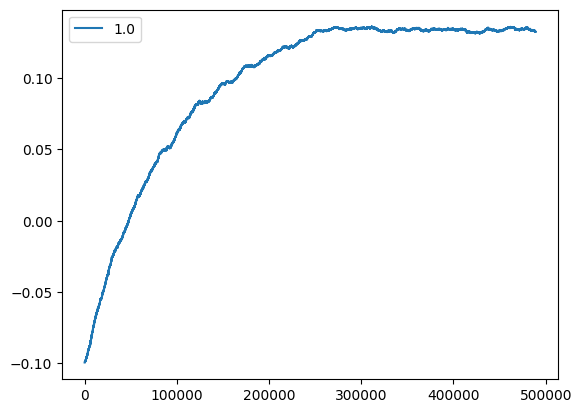

In [ ]:
# x = np.arange(len(prospect03_rewards[0]))
# y = prospect03_rewards[0]
# plt.plot(x,y, label = "0.3")

# x = np.arange(len(prospect05_rewards[0]))
# y = prospect05_rewards[0]
# plt.plot(x,y, label = "0.5")

# x = np.arange(len(prospect07_rewards[0]))
# y = prospect07_rewards[0]
# plt.plot(x,y, label = "0.7")

kernel_size = 11000
kernel = np.ones(kernel_size) / kernel_size

y = rewards_across_seeds[0]

y = np.convolve(y, kernel)

y = y[kernel_size:-kernel_size]


x = np.arange(len(y))

plt.plot(x,y, label = "1.0")

plt.legend()
plt.show()

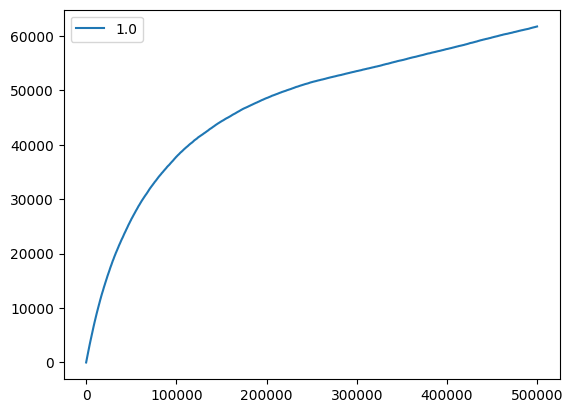

In [ ]:
# x = np.arange(len(prospect03_traps[0]))
# y = prospect03_traps[0]
# plt.plot(x,y, label = "0.3")

# x = np.arange(len(prospect05_traps[0]))
# y = prospect05_traps[0]
# plt.plot(x,y, label = "0.5")

# x = np.arange(len(prospect07_traps[0]))
# y = prospect07_traps[0]
# plt.plot(x,y, label = "0.7")

x = np.arange(len(traps_across_seeds[0]))
y = np.cumsum(traps_across_seeds[0])
plt.plot(x,y, label = "1.0")

plt.legend()
plt.show()

In [ ]:
#Old stuff at the bottom

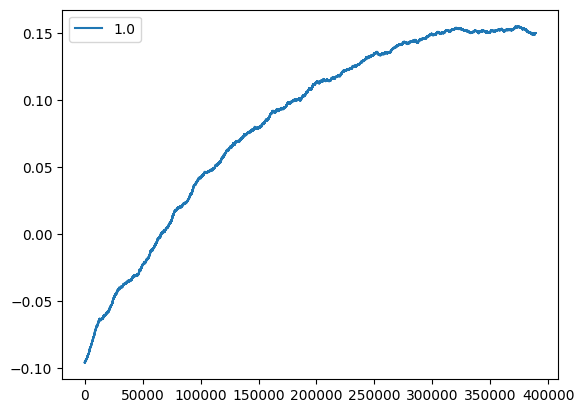

In [ ]:
# x = np.arange(len(prospect03_rewards[0]))
# y = prospect03_rewards[0]
# plt.plot(x,y, label = "0.3")

# x = np.arange(len(prospect05_rewards[0]))
# y = prospect05_rewards[0]
# plt.plot(x,y, label = "0.5")

# x = np.arange(len(prospect07_rewards[0]))
# y = prospect07_rewards[0]
# plt.plot(x,y, label = "0.7")

x = np.arange(len(prospect1_rewards[0]))
y = prospect1_rewards[0]
plt.plot(x,y, label = "1.0")

plt.legend()
plt.show()

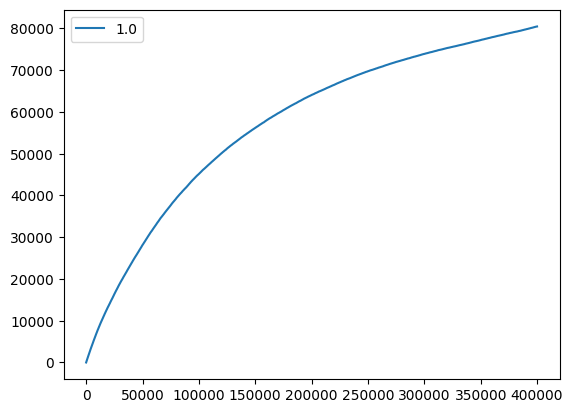

In [ ]:
# x = np.arange(len(prospect03_traps[0]))
# y = prospect03_traps[0]
# plt.plot(x,y, label = "0.3")

# x = np.arange(len(prospect05_traps[0]))
# y = prospect05_traps[0]
# plt.plot(x,y, label = "0.5")

# x = np.arange(len(prospect07_traps[0]))
# y = prospect07_traps[0]
# plt.plot(x,y, label = "0.7")

x = np.arange(len(prospect1_traps[0]))
y = prospect1_traps[0]
plt.plot(x,y, label = "1.0")

plt.legend()
plt.show()

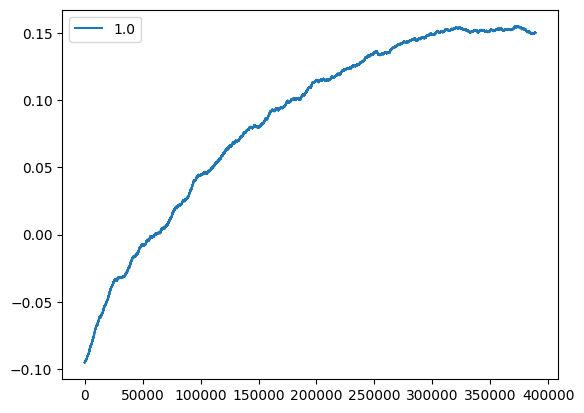

In [ ]:
# x = np.arange(len(prospect03_rewards[0]))
# y = prospect03_rewards[0]
# plt.plot(x,y, label = "0.3")

# x = np.arange(len(prospect05_rewards[0]))
# y = prospect05_rewards[0]
# plt.plot(x,y, label = "0.5")

# x = np.arange(len(prospect07_rewards[0]))
# y = prospect07_rewards[0]
# plt.plot(x,y, label = "0.7")

x = np.arange(len(prospect1_rewards[0]))
y = prospect1_rewards[0]
plt.plot(x,y, label = "1.0")

plt.legend()
plt.show()

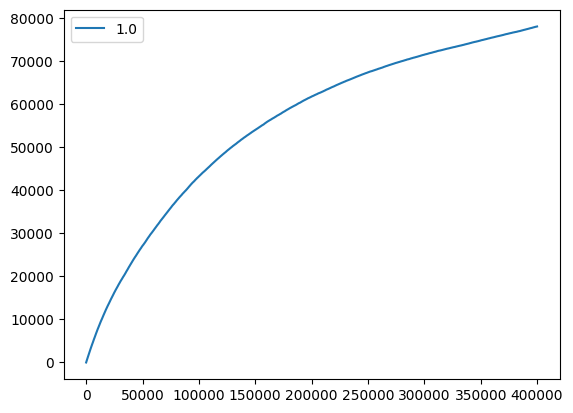

In [ ]:
# x = np.arange(len(prospect03_traps[0]))
# y = prospect03_traps[0]
# plt.plot(x,y, label = "0.3")

# x = np.arange(len(prospect05_traps[0]))
# y = prospect05_traps[0]
# plt.plot(x,y, label = "0.5")

# x = np.arange(len(prospect07_traps[0]))
# y = prospect07_traps[0]
# plt.plot(x,y, label = "0.7")

x = np.arange(len(prospect1_traps[0]))
y = prospect1_traps[0]
plt.plot(x,y, label = "1.0")

plt.legend()
plt.show()

In [ ]:
def compute_policy_weighted_entropy(self, state):

    tally_per_key = {}

    memoized_weighted_policy_entropy = {}
    for key, value in agent_obj.state_entropy2[state].items():

        
        tally = 0
        for k2, values2 in value.items():

            if(k2 in memoized_weighted_policy_entropy):
                tally += memoized_weighted_policy_entropy[k2]
            else:
                result = [a * b for a, b in zip(self.pi_table(int(k2)), values2)]
                memoized_weighted_policy_entropy[k2] = np.sum(result)
                tally += memoized_weighted_policy_entropy[k2]
            
        tally /= len(value.items())
        tally_per_key[key] = tally

    return tally_per_key

In [ ]:
def estimate_transitions(self,state_space, action_space, transition_stochasticity_level, steps_iterations):
    #This is needed to compute the next states only not for the estimate
    deterministic_env_obj = GridWorld(x_dim = 10, y_dim = 10, deterministic_T_prob = 1.0, reward_location=36, seed = 0)
    stochastic_05_env_obj = GridWorld(x_dim = 10, y_dim = 10, deterministic_T_prob = transition_stochasticity_level, reward_location=36, seed = 0)

        
    state_transitions = {}
    for i in range(state_space): ##State space
        actions_transitions = {}    

        for j in range(action_space): ##Action space
            actions = list(np.arange(action_space))
            
            delIndex = np.random.randint(action_space)
            while(delIndex == j):
                delIndex = np.random.randint(action_space)
            del actions[delIndex]
            
            j_index_action = np.where(np.array(actions) == j)[0][0]
                
            new_deterministic_state, _, _, _ = deterministic_env_obj.step(i, actions[j_index_action])
            new_deterministic_state = new_deterministic_state[0]

            total_steps = steps_iterations
            correct_step_count = 0
                
                
            for k in range(total_steps): #producing steps
                
                new_state, _, done, _ = stochastic_05_env_obj.step(i, actions[j_index_action] ) 
                new_state = new_state[0]
                
                if (new_deterministic_state == new_state ):
                    correct_step_count +=1

        
            correct_step_prob = correct_step_count/total_steps
            actions_probs_array = []
            for l in actions:
                if(l == actions[j_index_action]):
                    actions_probs_array.append( (correct_step_prob, new_deterministic_state) )
                else:
                    actions_probs_array.append( ( (1-correct_step_prob)/len(actions), None ))


            actions_transitions[ j ] = actions_probs_array


        state_transitions[i] = actions_transitions

    return state_transitions
